In [1]:
import numpy as np
import xgboost as xgb
import pandas
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.calibration import calibration_curve
from imblearn.over_sampling import SVMSMOTE,SMOTENC,SMOTE,ADASYN
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, auc, f1_score, precision_score, recall_score,plot_roc_curve, plot_precision_recall_curve
from sklearn import metrics
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold, train_test_split,cross_val_score
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, SGDClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVC
from sklearn.base import clone
import os
import random
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sb
import statsmodels.api as sm
from rfpimp import dropcol_importances
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib
# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Times New Roman"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

c:\Users\kvbsmith1\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#Helper Function to Conduct 5-Fold CV
#NOTE: This is a necessary cell and function to run subsequent analysis

def cycle_vars(X,y,X_test,Y_test,basis_vars,store_auc):
    rf = RandomForestClassifier(n_estimators = 800, random_state = 9,oob_score = True)
    # rf = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
    terminate = True
    initial_auc=0.5
    z=0
    while terminate == True:
        auc_vec = []
        # calculate univariate AUC scores
        for i in X.drop(basis_vars,axis=1).columns:
            #print current iterations of basis vars
#             print(", ".join(basis_vars)+', '+str(i))
            #try column in basis
            basis_vars.append(i)
            #get data for column enetering basis
            X_pass=X[X.columns[X.columns.isin(basis_vars)]]
            X_test_pass=X_test[X_test.columns[X_test.columns.isin(basis_vars)]]
            #train model
            rf.pred = rf.fit(X_pass,y).predict(X_test_pass)
            #display score
            #print(metrics.roc_auc_score(Y_test, rf.predict_proba(X_test_pass)[:,1]))
            #append value to larger list for later evaluation
            auc_vec.append(metrics.roc_auc_score(Y_test, rf.predict_proba(X_test_pass)[:,1]))
            #drop added variable
            basis_vars.pop(len(basis_vars)-1)
        # if there is no improvment, terminate
        z = z+1
        if max(auc_vec) < initial_auc:
            print(initial_auc)
            print(basis_vars)
            print('no improvement')
            X_pass=X[X.columns[X.columns.isin(basis_vars)]]
            X_test_pass=X_test[X_test.columns[X_test.columns.isin(basis_vars)]]
            #train model
            rf.pred = rf.fit(X_pass,y).predict(X_test_pass)
            rf_pred_prob = rf.predict_proba(X_test_pass)[:,1]
            print('Model trained using SAP-selected predictors: '+str(metrics.roc_auc_score(Y_test, rf.predict_proba(X_test_pass)[:,1])))
            rf_pred_full = rf.fit(X,y).predict(X_test)
            rf_pred_prob_full = rf.predict_proba(X_test)[:,1]
            full_auc = metrics.roc_auc_score(Y_test, rf.predict_proba(X_test)[:,1])
            print('Model trained using 41 Predictors: '+str(full_auc))
            
            Y_test_df = pandas.DataFrame((Y_test))
            six = pandas.DataFrame((rf.pred))
            six.index = Y_test_df.index
            full = pandas.DataFrame((rf_pred_full))
            full.index = Y_test_df.index
            six_prob = pandas.DataFrame((rf_pred_prob))
            six_prob.index = Y_test_df.index
            prob_full = pandas.DataFrame((rf_pred_prob_full))
            prob_full.index = Y_test_df.index
            pred_result_df = pandas.concat([six,full,Y_test_df,six_prob,prob_full], axis=1,ignore_index=False)
            terminate = False
        # otherwise, enter variable permanentely to basis
        else:
            basis_vars.append(X.drop(basis_vars,axis=1).columns[auc_vec.index(max(auc_vec))])
            store_auc.append(max(auc_vec))
            print(max(auc_vec))
            initial_auc = max(auc_vec)

    return [store_auc,basis_vars,pred_result_df,full_auc]

In [7]:
#RETROSPECTIVE OMICRON

rf = RandomForestClassifier(n_estimators = 800, random_state = 9,oob_score = True)
# rf = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

direc_list = ['C:\\Users\\kvbsmith1\\Documents\\github\\county-level-analysis\\single-test-coef\\april-30q',
            'C:\\Users\\kvbsmith1\\Documents\\github\\county-level-analysis\\single-test-coef\\100-fci',
              'C:\\Users\\kvbsmith1\\Documents\\github\\county-level-analysis\\single-test-coef\\march10',
              'C:\\Users\\kvbsmith1\\Documents\\github\\county-level-analysis\\single-test-coef\\50-fci',
              'C:\\Users\\kvbsmith1\\Documents\\github\\county-level-analysis\\single-test-coef\\april-30p'
              ]
scenario_list = ['=======100N Quartile=======',
                 '=======100C Quartile=======',
              '=======50N Presence=======',
              '=======50C Quartile=======',
              '=======100N Presence======='
              ]

# direc_list = ['C:\\Users\\kvbsmith1\\Documents\\github\\county-level-analysis\\single-test-coef\\april-30q']
# scenario_list = ['=======100N Quartile=======']

z=0
for j in range(len(direc_list)):
    #change directory from list
    os.chdir(direc_list[j])
    #print scenario underway
    print(scenario_list[j])
    #read data
    analysis_set = pandas.read_csv('analysis-tensor-vif-ba5.csv',index_col = 0)
    # analysis_set = analysis_set.reset_index()
    # analysis_set2 = pandas.read_csv('analysis-tensor-vif-omicron-dec.csv',index_col = 0)
    # np.isnan(analysis_set).to_csv('is_nan_ba5.csv')
    # np.isfinite(analysis_set).to_csv('is_inf_ba5.csv')
    # print(np.any(np.isnan(analysis_set)))
    # print(np.all(np.isfinite(analysis_set)))
    #drop dependent variable
    X = analysis_set.drop(['contained','omicron_quartile','com_lev_ind','ba5_quartile','ba5_levels'], axis=1)
    
    #denote dependent variable
    y = analysis_set['contained']
    new_y = analysis_set['ba5_quartile']
    #5-fold stratified cross validation
    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=9)
    k=0
    for train_index, test_index in rkf.split(X,y):
        #sequentially add variables to model until AUC score does not improve --- new_y.iloc[test_index]
        a = cycle_vars(X.iloc[train_index],y.iloc[train_index],X.iloc[test_index],new_y.iloc[test_index],[],[])
        #Concatenate AUC scores and their associated predictor selections
        result_df = pandas.concat([pandas.DataFrame(a[0]),pandas.DataFrame(a[1])],axis=1,ignore_index=True)
        #row bind the AUC scores and associated predictor selections with the full model score
        result_df = pandas.concat([result_df,pandas.DataFrame(np.array([a[3],'41p']).reshape(1,2))],axis=0,ignore_index=True)
        print(result_df.head)
        
        #If this is the first fold, initialize and fill lists and data frames
        if k == 0:
            pandas.concat([pandas.DataFrame(train_index),pandas.DataFrame(test_index)],axis=1).to_csv('ba5_temporal_training-testing-labels.csv')
            full_auc_list = []
            full_auc_list.append(a[3])
            short_auc_list = []
            short_auc_list.append(a[0][-1])
            large_table_result = result_df.copy()
            full_test_df = a[2].copy()
        #For all other folds besides the first, append the relevant information
        else:
            full_auc_list.append(a[3])
            short_auc_list.append(a[0][-1])
            large_table_result = pandas.concat([large_table_result,result_df],axis=1,ignore_index=True)
            full_test_df = pandas.concat([full_test_df,a[2]],axis=0)
            print(full_test_df)
        #iterate folds    
        k = k+1
        
        
    #save full results to csv table
    full_test_df.columns = ['SAP', '41P', 'Test',"Six_Prob","Full_Prob"]
    full_test_df = pandas.concat([X,full_test_df],axis=1) #ignore_index=True
    full_test_df.to_csv('temporal+baseline_ba5_full-data-pred-table-plus-prob.csv')
    large_table_result.to_csv('temporal+baseline_ba5_5-fold-additive.csv')
    print('41P AUC: %.3f (%.3f - %.3f)' % (np.mean(full_auc_list), np.mean(full_auc_list) - 2.776*np.std(full_auc_list), np.mean(full_auc_list) + 2.776*np.std(full_auc_list)))
    print('SAP AUC: %.3f (%.3f - %.3f)' % (np.mean(short_auc_list), np.mean(short_auc_list) - 2.776*np.std(short_auc_list), np.mean(short_auc_list) + 2.776*np.std(short_auc_list)))
    z = z+1

=======100C Quartile=======
0.6007144083068738
0.6993799879859264
0.7206513344203209
0.7456556251609027
0.7695765039045739
0.7752510083240367
0.7880588689607826
0.7902686003604222
0.7902686003604222
['case_ind2', 'pct_se_a12001_008', 'pct_se_a01001_009', 'pct_se_a10002b_007', 'apr_precipitation_inch', 'pct_se_a09005_005', 'pct_se_a10002b_005', 'pct_se_a01001_008']
no improvement
Model trained using SAP-selected predictors: 0.7902686003604222
Model trained using 41 Predictors: 0.6849630996309963
<bound method NDFrame.head of                     0                       1
0            0.600714               case_ind2
1             0.69938       pct_se_a12001_008
2            0.720651       pct_se_a01001_009
3            0.745656      pct_se_a10002b_007
4            0.769577  apr_precipitation_inch
5            0.775251       pct_se_a09005_005
6            0.788059      pct_se_a10002b_005
7            0.790269       pct_se_a01001_008
8  0.6849630996309963                     41p>
0.6054987

In [7]:
#A few calls to save the objects created above - not necessary if the function above is working.

full_test_df.to_csv('dec-omi_full-data-pred-table-plus-prob.csv')
large_table_result.to_csv('dec-omi_5-fold-additive.csv')
print('41P AUC: %.3f (%.3f - %.3f)' % (np.mean(full_auc_list), np.mean(full_auc_list) - 1.96*np.std(full_auc_list), np.mean(full_auc_list) + 1.96*np.std(full_auc_list)))
print('SAP AUC: %.3f (%.3f - %.3f)' % (np.mean(short_auc_list), np.mean(short_auc_list) - 1.96*np.std(short_auc_list), np.mean(short_auc_list) + 1.96*np.std(short_auc_list)))

NameError: name 'full_test_df' is not defined

In [6]:
#PROSPECTIVE OMICRON

rf = RandomForestClassifier(n_estimators = 800, random_state = 9,oob_score = True)

direc_list = ['C:\\Users\\kvbsmith1\\Documents\\github\\county-level-analysis\\single-test-coef\\50-fci',
              'C:\\Users\\kvbsmith1\\Documents\\github\\county-level-analysis\\single-test-coef\\april-30p',
              'C:\\Users\\kvbsmith1\\Documents\\github\\county-level-analysis\\single-test-coef\\100-fci',
              'C:\\Users\\kvbsmith1\\Documents\\github\\county-level-analysis\\single-test-coef\\april-30q',
              'C:\\Users\\kvbsmith1\\Documents\\github\\county-level-analysis\\single-test-coef\\march10']
scenario_list = ['=======50C Quartile=======',
              '=======100N Presence=======',
              '=======100C Quartile=======',
              '=======100N Quartile=======',
              '=======50N Presence=======']

# direc_list = ['C:\\Users\\kvbsmith1\\Documents\\github\\county-level-analysis\\single-test-coef\\march10']
# scenario_list = ['=======50N Presence=======']

z=0
for j in range(len(direc_list)):
    #change directory from list
    os.chdir(direc_list[j])
    #print scenario underway
    print(scenario_list[j])
    #read data
    analysis_set = pandas.read_csv('analysis-tensor-vif-omicron-dec_cases.csv',index_col = 0)
    #drop dependent variable
    X = analysis_set.drop(['ba5_quartile_11','omicron_quartile','contained'], axis=1)
    
    #denote dependent variable
    y = analysis_set['contained']
    new_y = analysis_set['omicron_quartile']
    #5-fold stratified cross validation
    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)
    k=0
    for train_index, test_index in rkf.split(X,y):
        #sequentially add variables to model until AUC score does not improve --- new_y.iloc[test_index]
        a = cycle_vars(X.iloc[train_index],y.iloc[train_index],X.iloc[test_index],new_y.iloc[test_index],[],[])
        #Concatenate AUC scores and their associated predictor selections
        result_df = pandas.concat([pandas.DataFrame(a[0]),pandas.DataFrame(a[1])],axis=1,ignore_index=True)
        #row bind the AUC scores and associated predictor selections with the full model score
        result_df = pandas.concat([result_df,pandas.DataFrame(np.array([a[3],'41p']).reshape(1,2))],axis=0,ignore_index=True)
        print(result_df.head)
        
        #If this is the first fold, initialize and fill lists and data frames
        if k == 0:
            pandas.concat([pandas.DataFrame(train_index),pandas.DataFrame(test_index)],axis=1).to_csv('training-testing-labels_cases_alpha_ba5.csv')
            full_auc_list = []
            full_auc_list.append(a[3])
            short_auc_list = []
            short_auc_list.append(a[0][-1])
            large_table_result = result_df.copy()
            full_test_df = a[2].copy()
        #For all other folds besides the first, append the relevant information
        else:
            full_auc_list.append(a[3])
            short_auc_list.append(a[0][-1])
            large_table_result = pandas.concat([large_table_result,result_df],axis=1,ignore_index=True)
            full_test_df = pandas.concat([full_test_df,a[2]],axis=0)
            print(full_test_df)
        #iterate folds    
        k = k+1
        
        
    #save full results to csv table
    full_test_df.columns = ['SAP', '41P', 'Test',"Six_Prob","Full_Prob"]
    full_test_df = pandas.concat([X,full_test_df],axis=1) #ignore_index=True
    full_test_df.to_csv('alpha_ba5-retro_full-data-pred-table-plus-prob_cases.csv')
    large_table_result.to_csv('alpha_ba5-retro_5-fold-additive_cases.csv')
    print('41P AUC: %.3f (%.3f - %.3f)' % (np.mean(full_auc_list), np.mean(full_auc_list) - 1.96*np.std(full_auc_list), np.mean(full_auc_list) + 1.96*np.std(full_auc_list)))
    print('SAP AUC: %.3f (%.3f - %.3f)' % (np.mean(short_auc_list), np.mean(short_auc_list) - 1.96*np.std(short_auc_list), np.mean(short_auc_list) + 1.96*np.std(short_auc_list)))
    z = z+1

=======50C Quartile=======
0.5576225344679728
0.5986938452404512
0.6207203641401148
0.6264397387690481
0.6264397387690481
['pct_se_a09001_006', 'x11_15_21', 'pct_se_a12001_008', 'ep_groupq']
no improvement
Model trained using SAP-selected predictors: 0.6264397387690481
Model trained using 41 Predictors: 0.42533148624579453
<bound method NDFrame.head of                      0                  1
0             0.557623  pct_se_a09001_006
1             0.598694          x11_15_21
2              0.62072  pct_se_a12001_008
3              0.62644          ep_groupq
4  0.42533148624579453                41p>
0.5800274371702943
0.6232480518194804
0.6232480518194804
['se_t012_003', 'x11_25_21']
no improvement
Model trained using SAP-selected predictors: 0.6232480518194804
Model trained using 41 Predictors: 0.38325059753631185
<bound method NDFrame.head of                      0            1
0             0.580027  se_t012_003
1             0.623248    x11_25_21
2  0.38325059753631185          41

In [5]:
#PROSPECTIVE BA.5

rf = RandomForestClassifier(n_estimators = 800, random_state = 9,oob_score = True)

direc_list = ['C:\\Users\\kvbsmith1\\Documents\\github\\county-level-analysis\\single-test-coef\\50-fci']
scenario_list = ['=======50C Quartile=======']

z=0
for j in range(len(direc_list)):
    #change directory from list
    os.chdir(direc_list[j])
    #print scenario underway
    print(scenario_list[j])
    #read data
    analysis_set = pandas.read_csv('analysis-tensor-vif-omicron-ba5_cases.csv',index_col = 0)
    #drop dependent variable
    X = analysis_set.drop(['ba5_quartile_11','omicron_quartile','contained'], axis=1)
    
    #denote dependent variable
    y = analysis_set['omicron_quartile']
    new_y = analysis_set['ba5_quartile_11']
    #5-fold stratified cross validation
    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)
    k=0
    for train_index, test_index in rkf.split(X,y):
        #sequentially add variables to model until AUC score does not improve --- new_y.iloc[test_index]
        a = cycle_vars(X.iloc[train_index],y.iloc[train_index],X.iloc[test_index],new_y.iloc[test_index],[],[])
        #Concatenate AUC scores and their associated predictor selections
        result_df = pandas.concat([pandas.DataFrame(a[0]),pandas.DataFrame(a[1])],axis=1,ignore_index=True)
        #row bind the AUC scores and associated predictor selections with the full model score
        result_df = pandas.concat([result_df,pandas.DataFrame(np.array([a[3],'41p']).reshape(1,2))],axis=0,ignore_index=True)
        print(result_df.head)
        
        #If this is the first fold, initialize and fill lists and data frames
        if k == 0:
            pandas.concat([pandas.DataFrame(train_index),pandas.DataFrame(test_index)],axis=1).to_csv('training-testing-labels.csv')
            full_auc_list = []
            full_auc_list.append(a[3])
            short_auc_list = []
            short_auc_list.append(a[0][-1])
            large_table_result = result_df.copy()
            full_test_df = a[2].copy()
        #For all other folds besides the first, append the relevant information
        else:
            full_auc_list.append(a[3])
            short_auc_list.append(a[0][-1])
            large_table_result = pandas.concat([large_table_result,result_df],axis=1,ignore_index=True)
            full_test_df = pandas.concat([full_test_df,a[2]],axis=0)
            print(full_test_df)
        #iterate folds    
        k = k+1
        
        
    #save full results to csv table
    full_test_df.columns = ['SAP', '41P', 'Test',"Six_Prob","Full_Prob"]
    full_test_df = pandas.concat([X,full_test_df],axis=1) #ignore_index=True
    full_test_df.to_csv('july-ba5-retro_full-data-pred-table-plus-prob_cases.csv')
    large_table_result.to_csv('july-ba5-retro_5-fold-additive_cases.csv')
    print('41P AUC: %.3f (%.3f - %.3f)' % (np.mean(full_auc_list), np.mean(full_auc_list) - 1.96*np.std(full_auc_list), np.mean(full_auc_list) + 1.96*np.std(full_auc_list)))
    print('SAP AUC: %.3f (%.3f - %.3f)' % (np.mean(short_auc_list), np.mean(short_auc_list) - 1.96*np.std(short_auc_list), np.mean(short_auc_list) + 1.96*np.std(short_auc_list)))
    z = z+1

=======50C Quartile=======
0.8961361711580381
0.9666166854096381
0.9807502742027295
0.9854221333666542
0.9872964305052272
0.9888791703111334
0.9890874255487526
0.9895108778652449
0.9895108778652449
['x11_22_21', 'se_a00002_002', 'x6_17_22', 'se_a00002_003', 'x6_12_22', 'pct_se_a12001_008', 'x6_9_22', 'se_t012_003']
no improvement
Model trained using SAP-selected predictors: 0.9895108778652449
Model trained using 41 Predictors: 0.9865814208560679
<bound method NDFrame.head of                     0                  1
0            0.896136          x11_22_21
1            0.966617      se_a00002_002
2             0.98075           x6_17_22
3            0.985422      se_a00002_003
4            0.987296           x6_12_22
5            0.988879  pct_se_a12001_008
6            0.989087            x6_9_22
7            0.989511        se_t012_003
8  0.9865814208560679                41p>
0.8972447657368887
0.9497033349246403
0.9669849280501944
0.9746982200095479
0.979438041328514
0.9816817840823

In [ ]:
#RETROSPECTIVE BA.5

rf = RandomForestClassifier(n_estimators = 800, random_state = 9,oob_score = True)

direc_list = ['C:\\Users\\kvbsmith1\\Documents\\github\\county-level-analysis\\single-test-coef\\50-fci']
scenario_list = ['=======50C Quartile=======']

z=0
for j in range(len(direc_list)):
    #change directory from list
    os.chdir(direc_list[j])
    #print scenario underway
    print(scenario_list[j])
    #read data
    analysis_set = pandas.read_csv('analysis-tensor-vif-omicron-ba5.csv',index_col = 0)
    #drop dependent variable
    X = analysis_set.drop(['ba5_quartile_11','omicron_quartile','contained'], axis=1)
    
    #denote dependent variable
    y = analysis_set['ba5_quartile_11']
    new_y = analysis_set['ba5_quartile_11']
    #5-fold stratified cross validation
    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)
    k=0
    for train_index, test_index in rkf.split(X,y):
        #sequentially add variables to model until AUC score does not improve --- new_y.iloc[test_index]
        a = cycle_vars(X.iloc[train_index],y.iloc[train_index],X.iloc[test_index],new_y.iloc[test_index],[],[])
        #Concatenate AUC scores and their associated predictor selections
        result_df = pandas.concat([pandas.DataFrame(a[0]),pandas.DataFrame(a[1])],axis=1,ignore_index=True)
        #row bind the AUC scores and associated predictor selections with the full model score
        result_df = pandas.concat([result_df,pandas.DataFrame(np.array([a[3],'41p']).reshape(1,2))],axis=0,ignore_index=True)
        print(result_df.head)
        
        #If this is the first fold, initialize and fill lists and data frames
        if k == 0:
            pandas.concat([pandas.DataFrame(train_index),pandas.DataFrame(test_index)],axis=1).to_csv('training-testing-labels.csv')
            full_auc_list = []
            full_auc_list.append(a[3])
            short_auc_list = []
            short_auc_list.append(a[0][-1])
            large_table_result = result_df.copy()
            full_test_df = a[2].copy()
        #For all other folds besides the first, append the relevant information
        else:
            full_auc_list.append(a[3])
            short_auc_list.append(a[0][-1])
            large_table_result = pandas.concat([large_table_result,result_df],axis=1,ignore_index=True)
            full_test_df = pandas.concat([full_test_df,a[2]],axis=0)
            print(full_test_df)
        #iterate folds    
        k = k+1
        
        
    #save full results to csv table
    full_test_df.columns = ['SAP', '41P', 'Test',"Six_Prob","Full_Prob"]
    full_test_df = pandas.concat([X,full_test_df],axis=1) #ignore_index=True
    full_test_df.to_csv('dec-omi-retro_full-data-pred-table-plus-prob.csv')
    large_table_result.to_csv('dec-omi-retro_5-fold-additive.csv')
    print('41P AUC: %.3f (%.3f - %.3f)' % (np.mean(full_auc_list), np.mean(full_auc_list) - 1.96*np.std(full_auc_list), np.mean(full_auc_list) + 1.96*np.std(full_auc_list)))
    print('SAP AUC: %.3f (%.3f - %.3f)' % (np.mean(short_auc_list), np.mean(short_auc_list) - 1.96*np.std(short_auc_list), np.mean(short_auc_list) + 1.96*np.std(short_auc_list)))
    z = z+1

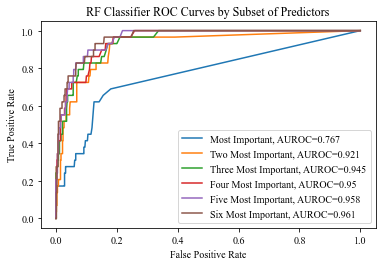

In [3]:
#An example to illustrate the addition of independent variable's contribution to AUROC
#NOTE: This example is **reproducible** due to the random_state=101

os.chdir('...\single-test-coef\\march10')
rf = RandomForestClassifier(n_estimators = 800, random_state = 101,oob_score = True)
#read data
analysis_set = pandas.read_csv('analysis-tensor-vif.csv',index_col = 0)
#drop dependent variable
X = analysis_set.drop('contained', axis=1)
X8 = X[['se_a00002_002','jul_precipitation_inch','pct_se_a01001_005','all_icu','se_a00002_003','pct_se_a01001_008','apr_precipitation_inch','pct_se_a09005_005']]
X7 = X[['se_a00002_002','jul_precipitation_inch','pct_se_a01001_005','all_icu','se_a00002_003','pct_se_a01001_008','pct_se_a09001_005']]
X6=X[['se_a00002_002','jul_precipitation_inch','pct_se_a01001_005','all_icu','se_a00002_003','pct_se_a01001_008']]
X5=X[['se_a00002_002','jul_precipitation_inch','pct_se_a01001_005','all_icu','se_a00002_003']]
X4=X[['se_a00002_002','jul_precipitation_inch','pct_se_a01001_005','all_icu']]
X3=X[['se_a00002_002','jul_precipitation_inch','pct_se_a01001_005']]
X2=X[['se_a00002_002','jul_precipitation_inch']]
X1=X[['se_a00002_002']]

#set dependent variable
y = analysis_set['contained']


# matplotlib.rcParams['font.serif'] = ['times']
plt.figure(0,figsize=[6,3.8]).clf()

X_data, X_test, Y_data, Y_test = train_test_split(X1, y, test_size=0.2, random_state=101,stratify=y)
rf.pred = rf.fit(X_data,Y_data)
# metrics.plot_roc_curve(rf,X_test, Y_test)
# plt.show()
fpr, tpr, thresh = metrics.roc_curve(Y_test, rf.predict_proba(X_test)[:,1])
auc = round(metrics.roc_auc_score(Y_test, rf.predict_proba(X_test)[:,1]),3)
plt.plot(fpr,tpr,label="Most Important, AUROC="+str(auc))

X_data, X_test, Y_data, Y_test = train_test_split(X2, y, test_size=0.2, random_state=101,stratify=y)
rf.pred = rf.fit(X_data,Y_data)
# metrics.plot_roc_curve(rf,X_test, Y_test)
# plt.show()
fpr, tpr, thresh = metrics.roc_curve(Y_test, rf.predict_proba(X_test)[:,1])
auc = round(metrics.roc_auc_score(Y_test, rf.predict_proba(X_test)[:,1]),3)
plt.plot(fpr,tpr,label="Two Most Important, AUROC="+str(auc))

X_data, X_test, Y_data, Y_test = train_test_split(X3, y, test_size=0.2, random_state=101,stratify=y)
rf.pred = rf.fit(X_data,Y_data)
# metrics.plot_roc_curve(rf,X_test, Y_test)
# plt.show()
fpr, tpr, thresh = metrics.roc_curve(Y_test, rf.predict_proba(X_test)[:,1])
auc = round(metrics.roc_auc_score(Y_test, rf.predict_proba(X_test)[:,1]),3)
plt.plot(fpr,tpr,label="Three Most Important, AUROC="+str(auc))

X_data, X_test, Y_data, Y_test = train_test_split(X4, y, test_size=0.2, random_state=101,stratify=y)
rf.pred = rf.fit(X_data,Y_data)
# metrics.plot_roc_curve(rf,X_test, Y_test)
# plt.show()
fpr, tpr, thresh = metrics.roc_curve(Y_test, rf.predict_proba(X_test)[:,1])
auc = round(metrics.roc_auc_score(Y_test, rf.predict_proba(X_test)[:,1]),3)
plt.plot(fpr,tpr,label="Four Most Important, AUROC="+str(auc))

X_data, X_test, Y_data, Y_test = train_test_split(X5, y, test_size=0.2, random_state=101,stratify=y)
rf.pred = rf.fit(X_data,Y_data)
# metrics.plot_roc_curve(rf,X_test, Y_test)
# plt.show()
fpr, tpr, thresh = metrics.roc_curve(Y_test, rf.predict_proba(X_test)[:,1])
auc = round(metrics.roc_auc_score(Y_test, rf.predict_proba(X_test)[:,1]),3)
plt.plot(fpr,tpr,label="Five Most Important, AUROC="+str(auc))

X_data, X_test, Y_data, Y_test = train_test_split(X6, y, test_size=0.2, random_state=101,stratify=y)
rf.pred = rf.fit(X_data,Y_data)
# metrics.plot_roc_curve(rf,X_test, Y_test)
# plt.show()
fpr, tpr, thresh = metrics.roc_curve(Y_test, rf.predict_proba(X_test)[:,1])
auc = round(metrics.roc_auc_score(Y_test, rf.predict_proba(X_test)[:,1]),3)
plt.plot(fpr,tpr,label="Six Most Important, AUROC="+str(auc)) #,'r+'

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF Classifier ROC Curves by Subset of Predictors')
plt.legend(loc=0)

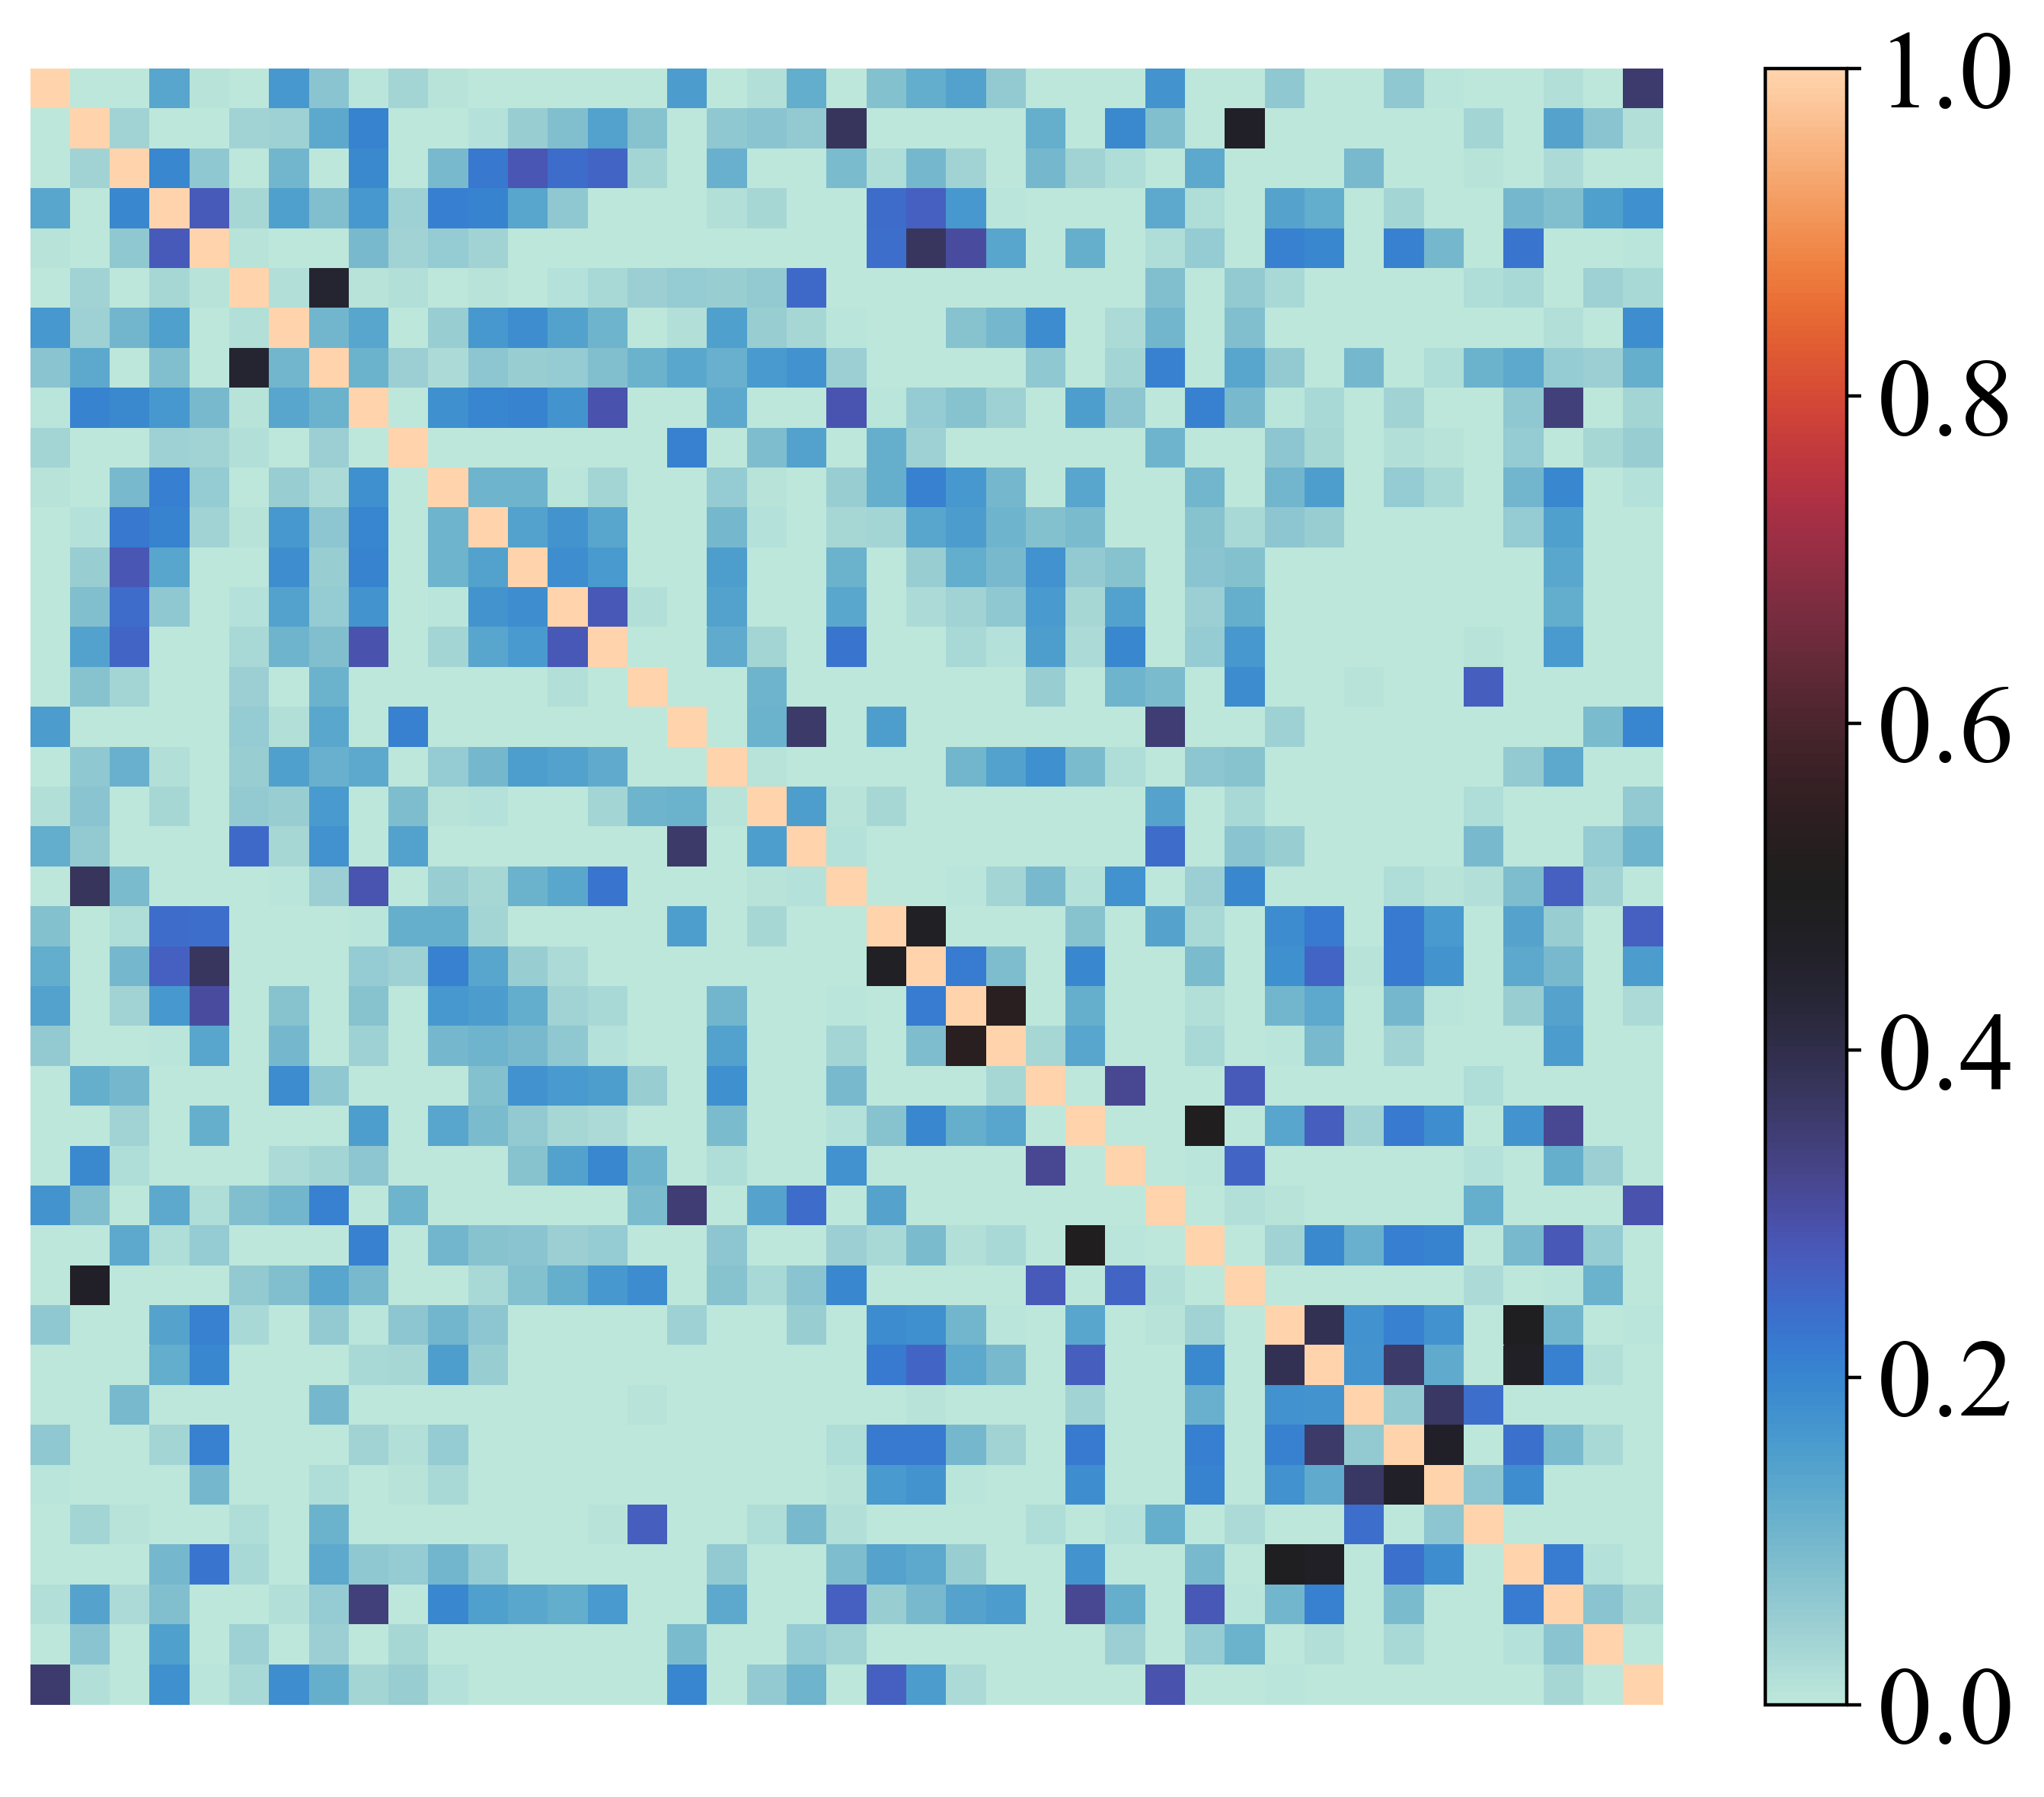

In [4]:
#Generates an image of the correlation matrix of all VIF-selected independent variables
#NOTE: Results are included in supplement.
#NOTE: May need to change the options to generate a plot 
#      that has the independent variable labels on the axes

os.chdir('...\single-test-coef\\april-30p')

#FULL set

#read data
analysis_set = pandas.read_csv('analysis-tensor-vif.csv',index_col = 0)
#drop dependent variable
X = analysis_set.drop('contained', axis=1)

# create seaborn heatmap with required labels
fig = plt.figure(figsize=(7,6),dpi=400)
_ = sb.heatmap(X.corr(),cmap="icefire",annot_kws={"fontsize":17}, vmin=0, vmax=1,cbar=False,cbar_kws={'label': 'Pairwise Correlation'}) #YlGnBu,xticklabels=x_axis_labels, yticklabels=y_axis_labels
# _.figure.axes[-1].set_ylabel('Accuracy %', size=20)
# _.ax.tick_params(labelsize=20)
# _.set_yticklabels(labels=_.get_yticklabels(), va='center',rotation=0)
# _.set_xticklabels(labels=_.get_xticklabels(),rotation=35,ha='right')
cb=_.figure.colorbar(_.collections[0]) #Display colorbar

cb.ax.tick_params(labelsize=26)
_.set(xticklabels=[])
_.set(yticklabels=[])
_.tick_params(bottom=False)
_.tick_params(left=False)
# _.set_xticklabels(_.get_xmajorticklabels(), fontsize = 12)
# _.set_yticklabels(_.get_ymajorticklabels(), fontsize = 12)

fig.tight_layout()
fig.savefig('vif-correlation.png')

plt.show()


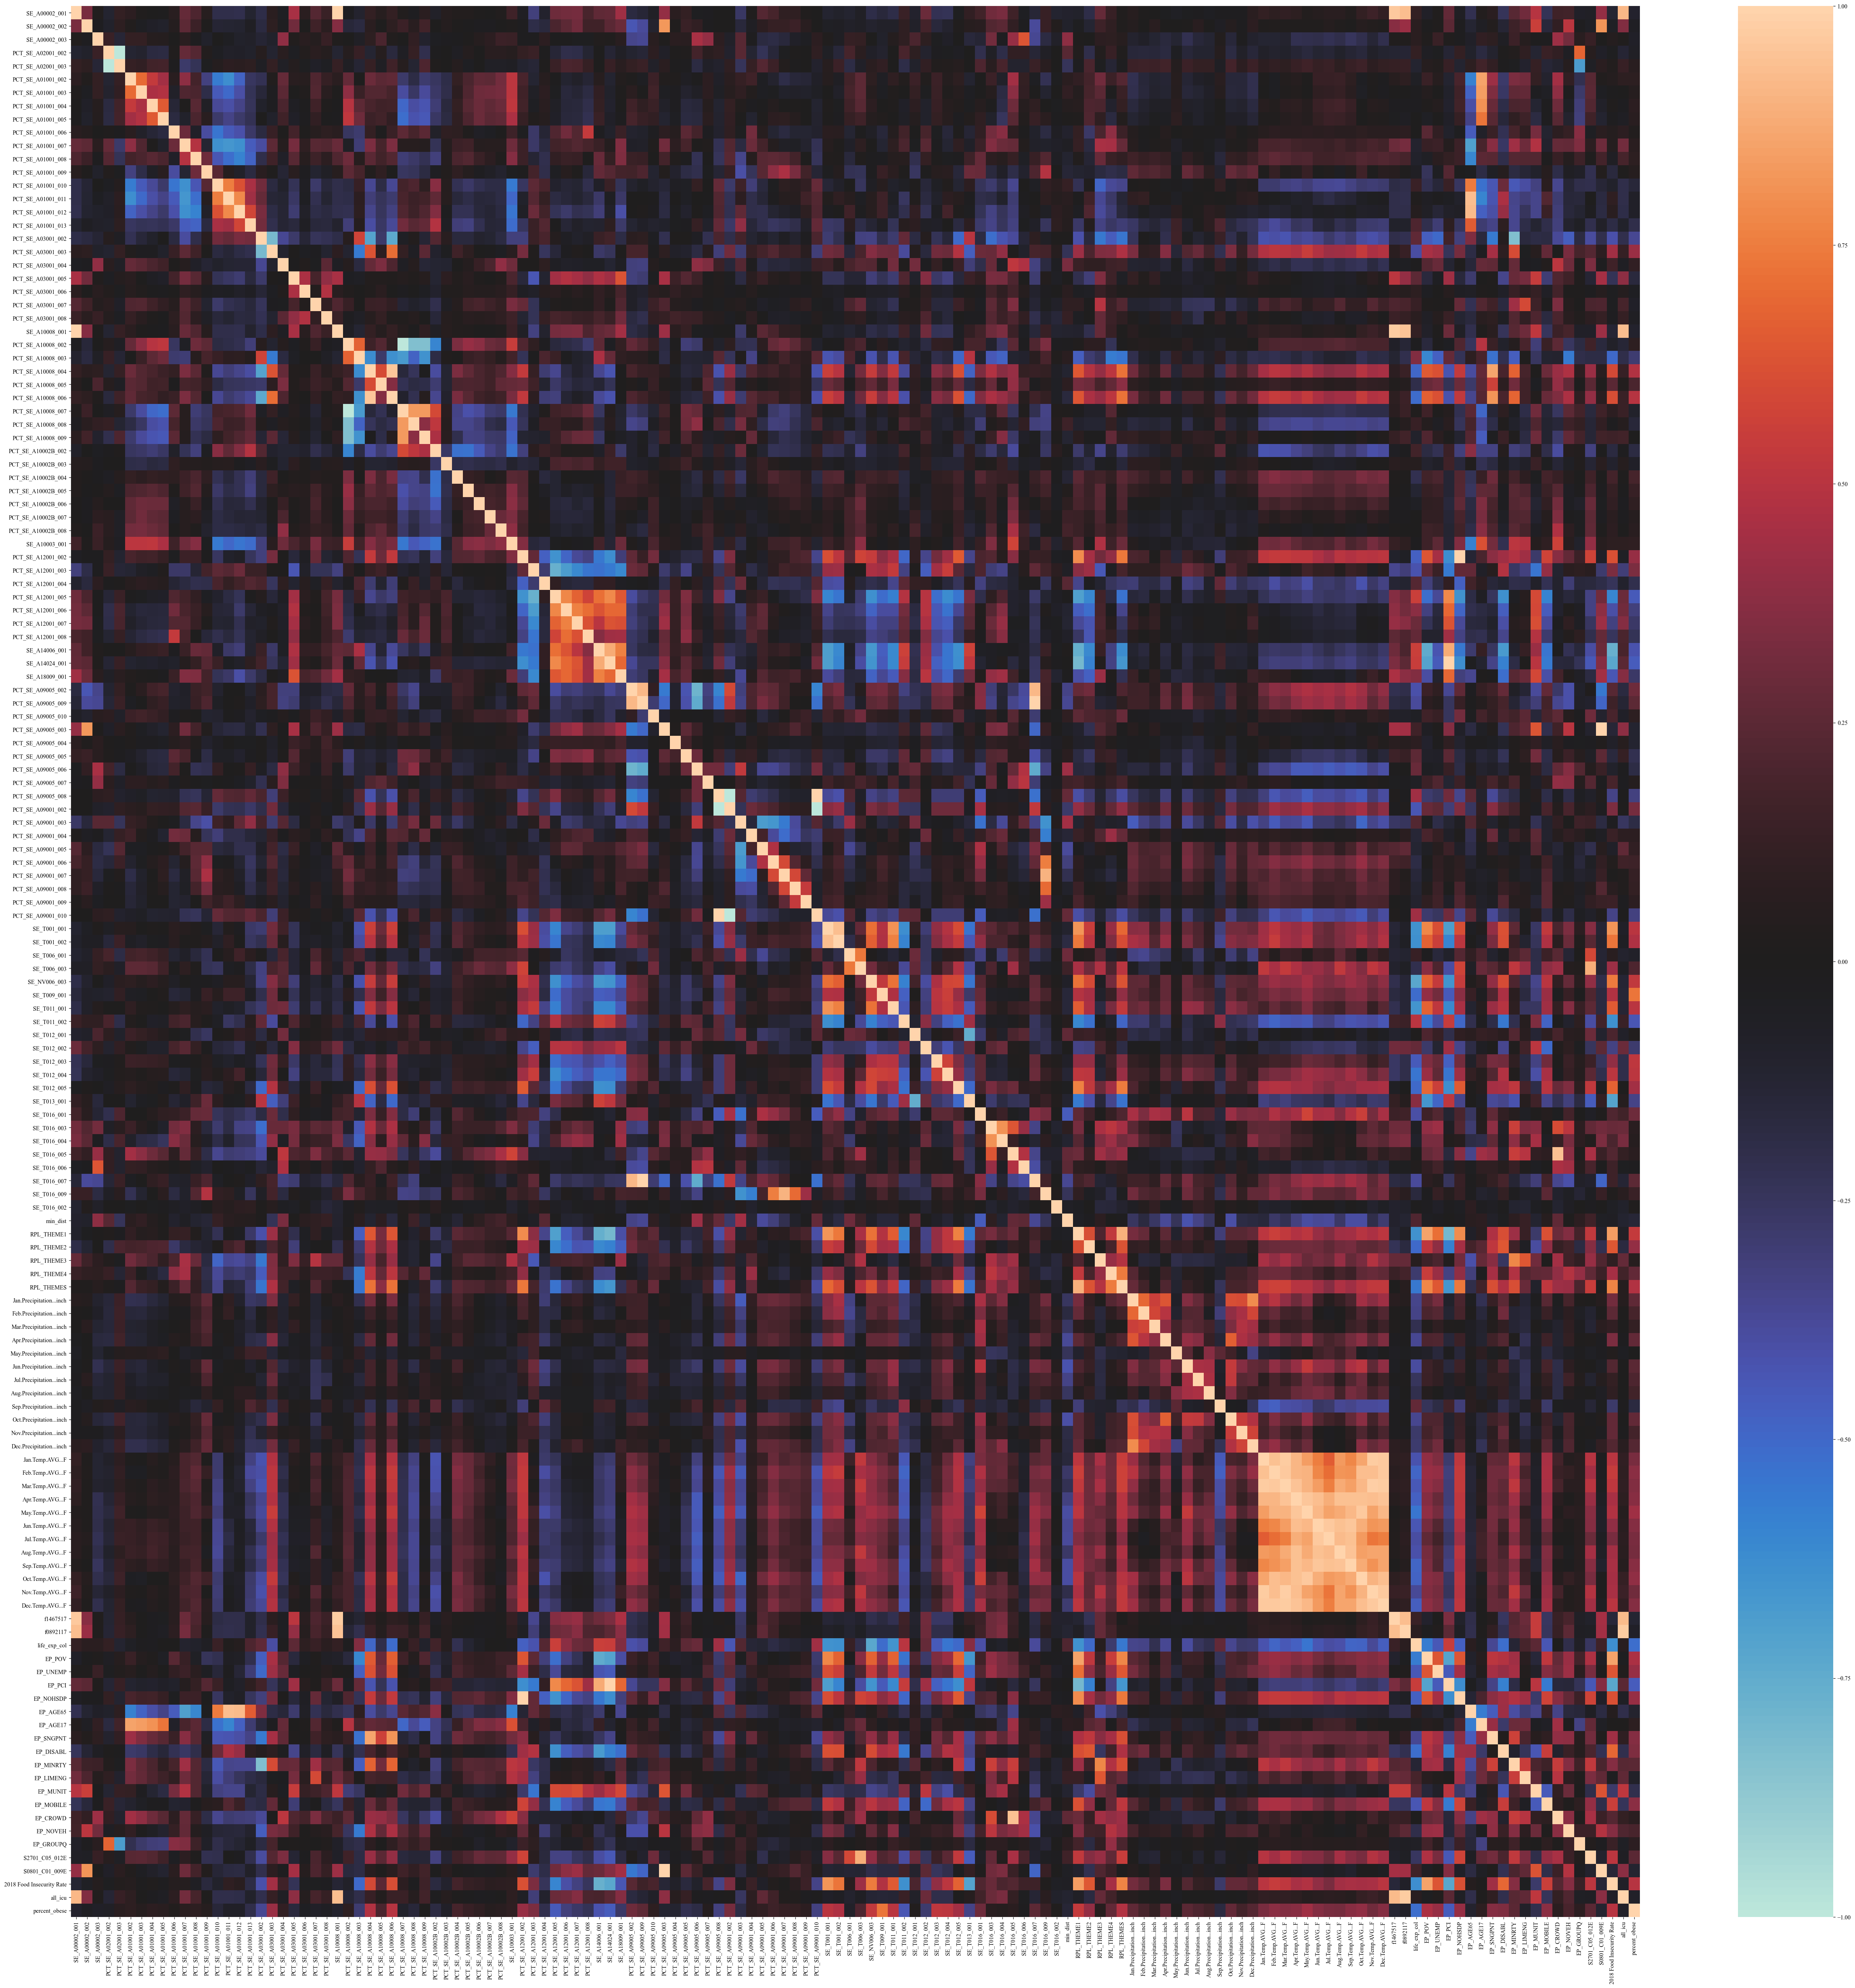

In [5]:
#Generates an image of the correlation matrix of all predictors collected for the study
#NOTE: outdated analysis and results are not included in manuscript or supplement.

#set figure dimensions and parameters
fig = plt.figure(figsize=(60,60),dpi=120)
#produce correlation matrix of full predictor set
os.chdir('...\single-test-coef\\april-30p')
analysis_set = pandas.read_csv('analysis-tensor-largest.csv',index_col = 0)
#drop dependent variable
X = analysis_set.drop('contained', axis=1)
_ = sb.heatmap(X.corr(),cmap="icefire")
#plt.show()
